Single batch correlation

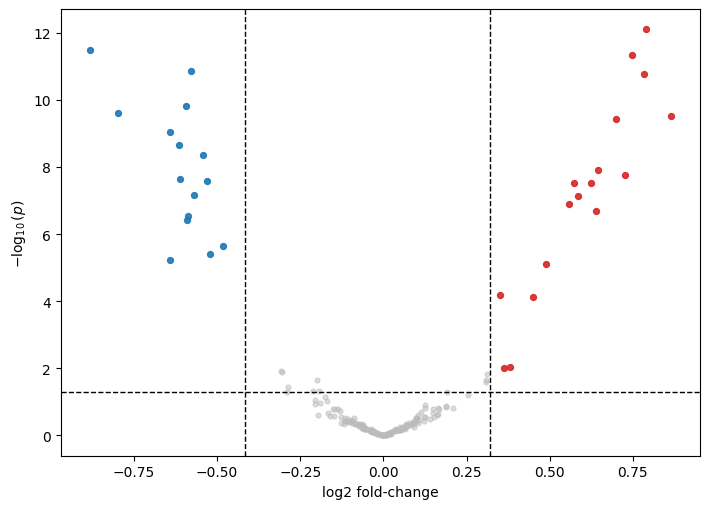

Training accuracy: 1.0
corr(|log2FC| × -log10 p, |avg grad|) = 0.909
corr(log2FC × -log10 p, avg grad)    = 0.923


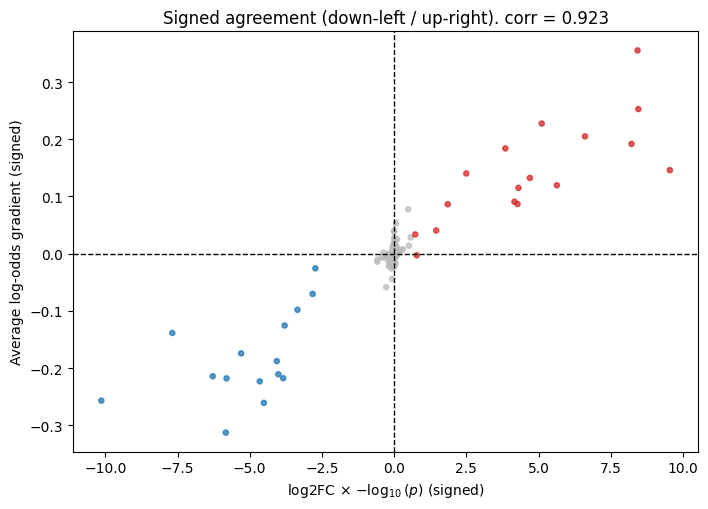

Saved: synthetic_keras_volcano_weighted\feature_results.csv


In [5]:
# %% [markdown]
# # 🔬 Synthetic Volcano vs Gradient (Keras)
# Demonstrates correlation between statistical effects and model saliency.
# Volcano thresholds: p ≤ 0.05; FC ≤ 0.5 (down) or FC ≥ 2 (up).
# For correlation, we use signed metric (log2FC × -log10 p) vs signed avg log-odds gradients.

# %%
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from pathlib import Path

# %% Configuration
np.random.seed(7)
tf.random.set_seed(7)
OUT_DIR = Path("synthetic_keras_volcano_weighted"); OUT_DIR.mkdir(exist_ok=True)
N_CTRL, N_CASE, D = 50, 50, 200
N_UP, N_DOWN, EFFECT, NOISE_SD = 15, 15, 1.2, 1.0

# Volcano thresholds requested:
P_THRESH = 0.05
FC_LOW, FC_HIGH = 0.75, 1.25               # fold-change on the raw scale
LFC_LOW, LFC_HIGH = np.log2(FC_LOW), np.log2(FC_HIGH)  # -1.0 and +1.0

# %% Synthetic dataset (same as before)
X_ctrl = np.random.normal(0, NOISE_SD, (N_CTRL, D)).astype(np.float32)
X_case = np.random.normal(0, NOISE_SD, (N_CASE, D)).astype(np.float32)
idx = np.random.permutation(D)
idx_up, idx_down = idx[:N_UP], idx[N_UP:N_UP+N_DOWN]
X_case[:, idx_up] += EFFECT
X_case[:, idx_down] -= EFFECT
X = np.vstack([X_ctrl, X_case])
y = np.array([0]*N_CTRL + [1]*N_CASE)

# %% Volcano statistics
def bh_fdr(p):
    n=len(p); o=np.argsort(p); r=p[o]; q=np.empty(n); prev=1
    for i in range(n-1,-1,-1):
        prev=min(prev, r[i]*n/(i+1)); q[i]=prev
    out=np.empty(n); out[o]=q; return out

def safe_log2fc(case, ctrl, eps=1e-6):
    shift = max(0, -min(case.min(), ctrl.min())) + eps
    return np.log2(((case+shift).mean()+eps) / ((ctrl+shift).mean()+eps))

lfc = np.zeros(D); pvals = np.ones(D)
for j in range(D):
    t, p = stats.ttest_ind(X_case[:, j], X_ctrl[:, j], equal_var=False)
    pvals[j] = 1 if np.isnan(p) else p
    lfc[j] = safe_log2fc(X_case[:, j], X_ctrl[:, j])

qvals = bh_fdr(pvals)
neglog10p = -np.log10(pvals + 1e-300)

# Significance using your requested cutoffs
sig_up   = (pvals <= P_THRESH) & (lfc >= LFC_HIGH)   # FC ≥ 2
sig_down = (pvals <= P_THRESH) & (lfc <= LFC_LOW)    # FC ≤ 0.5
sig_any  = sig_up | sig_down

# %% Volcano plot with colors and thresholds
plt.figure(figsize=(7.2, 5.2))
# not significant
plt.scatter(lfc[~sig_any], neglog10p[~sig_any], s=12, alpha=0.5, c="#bbbbbb", label="Not significant")
# down
plt.scatter(lfc[sig_down], neglog10p[sig_down], s=18, alpha=0.9, c="#1f77b4", label="Down (p≤0.05 & FC≤0.5)")
# up
plt.scatter(lfc[sig_up],   neglog10p[sig_up],   s=18, alpha=0.9, c="#d62728", label="Up (p≤0.05 & FC≥2)")

# threshold lines
plt.axvline(LFC_LOW,  ls='--', lw=1, c='k')
plt.axvline(LFC_HIGH, ls='--', lw=1, c='k')
plt.axhline(-np.log10(P_THRESH), ls='--', lw=1, c='k')
plt.xlabel("log2 fold-change")
plt.ylabel(r"$-\log_{10}(p)$")
plt.tight_layout()
plt.show()

# %% Build + train model (same arch)
def build_model(input_dim):
    m = Sequential([
        Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.01), input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')
    ])
    m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return m

Xn = (X - X.mean(0)) / (X.std(0) + 1e-6)
m = build_model(D)
m.fit(Xn, y, epochs=25, batch_size=16, verbose=0)
print("Training accuracy:", m.evaluate(Xn, y, verbose=0)[1])

# %% Average log-odds gradients (signed)
@tf.function(reduce_retracing=True)
def logodds_grad(x1, model, eps=1e-8):
    with tf.GradientTape() as t:
        t.watch(x1)
        p = model(x1, training=False)
        logodds = tf.math.log(p[:, 1] + eps) - tf.math.log(p[:, 0] + eps)
    return tf.squeeze(t.gradient(logodds, x1), 0)

X_t = tf.convert_to_tensor(Xn, dtype=tf.float32)
grads = [logodds_grad(X_t[i:i+1], m).numpy() for i in range(len(X_t))]
avg_grad   = np.mean(grads, axis=0)         # signed average gradient
grad_mag   = np.abs(avg_grad)

# %% Signed & absolute agreement metrics
eps = 1e-300
volcano_weight = -np.log10(pvals + eps)

metric_signed = lfc * volcano_weight          # negative for down, positive for up
metric_abs    = np.abs(lfc) * volcano_weight

# Correlations
corr_abs    = np.corrcoef(metric_abs, grad_mag)[0, 1]
corr_signed = np.corrcoef(metric_signed, avg_grad)[0, 1]

print(f"corr(|log2FC| × -log10 p, |avg grad|) = {corr_abs:.3f}")
print(f"corr(log2FC × -log10 p, avg grad)    = {corr_signed:.3f}")

# %% Scatter: signed effect vs signed gradient (down on negative axes)
plt.figure(figsize=(7.2, 5.2))
plt.axhline(0, lw=1, c='k', ls='--')
plt.axvline(0, lw=1, c='k', ls='--')
# color by direction using same scheme as volcano
colors = np.full(D, "#bbbbbb", dtype=object)
colors[sig_down] = "#1f77b4"
colors[sig_up]   = "#d62728"
plt.scatter(metric_signed, avg_grad, s=14, alpha=0.75, c=colors)
plt.xlabel(r"log2FC × $-\log_{10}(p)$ (signed)")
plt.ylabel("Average log-odds gradient (signed)")
plt.title(f"Signed agreement (down-left / up-right). corr = {corr_signed:.3f}")
plt.tight_layout()
plt.show()

# %% Save results
out_df = pd.DataFrame({
    "feature": np.arange(D),
    "log2FC": lfc,
    "p_value": pvals,
    "q_value": qvals,
    "grad_avg": avg_grad,
    "grad_mag": grad_mag,
    "volcano_weight": volcano_weight,
    "metric_abs": metric_abs,
    "metric_signed": metric_signed,
    "sig_up": sig_up,
    "sig_down": sig_down
})
out_fp = OUT_DIR / "feature_results.csv"
out_df.to_csv(out_fp, index=False)
print("Saved:", out_fp)



Two batch embedding

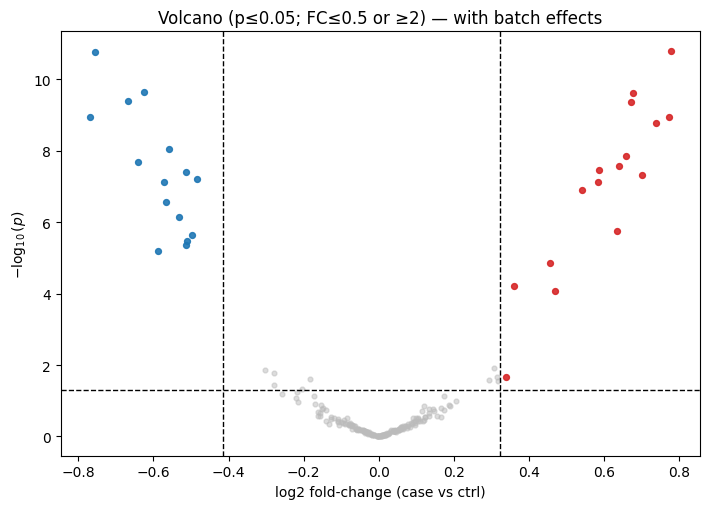

   feature  p_treatment   p_batch  p_interaction  q_treatment   q_batch  \
0        0     0.452308  0.027717       0.112994     0.876230  0.066788   
1        1     0.169123  0.000869       0.436453     0.564679  0.003779   
2        2     0.012815  0.868240       0.642350     0.075384  0.928599   
3        3     0.091044  0.000002       0.081917     0.387423  0.000021   
4        4     0.210448  0.052169       0.606138     0.668088  0.106467   

   q_interaction  
0       0.858465  
1       0.858465  
2       0.858465  
3       0.858465  
4       0.858465  
Training accuracy (with batch embedding): 1.0
corr(|log2FC| × -log10 p, |avg grad|) = 0.912
corr(log2FC × -log10 p, avg grad)    = 0.923


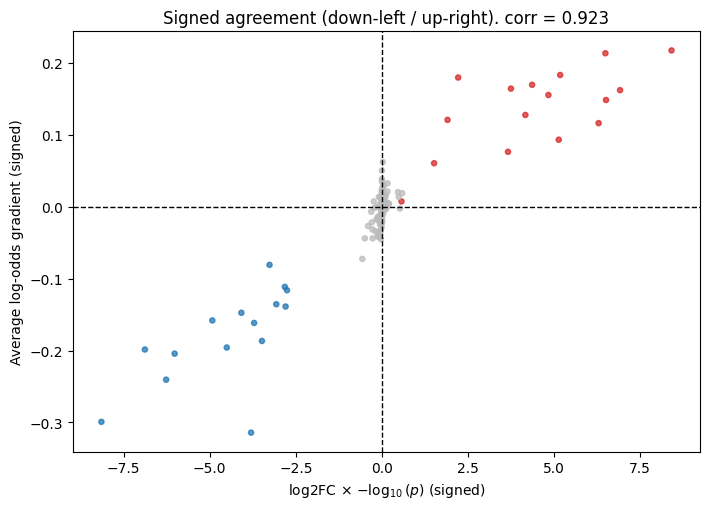

Saved: synthetic_keras_volcano_weighted\feature_results_with_anova.csv


In [4]:
# %% [markdown]
# # 🔬 Synthetic Volcano vs Gradient (Keras) — with Batches, Two-Way ANOVA, and Batch Embedding
# Adds: (1) two synthetic batches, (2) per-feature two-way ANOVA (Treatment, Batch, Interaction),
# (3) neural network that embeds the batch and concatenates it to the feature input.

# %%
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from pathlib import Path

# Two-way ANOVA
try:
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
except Exception as e:
    raise ImportError("statsmodels is required. Install with: pip install statsmodels") from e

# %% Configuration
np.random.seed(7)
tf.random.set_seed(7)

OUT_DIR = Path("synthetic_keras_volcano_weighted"); OUT_DIR.mkdir(exist_ok=True)

# samples & features
N_CTRL, N_CASE, D = 50, 50, 200
N_UP, N_DOWN, EFFECT, NOISE_SD = 15, 15, 1.2, 1.0

# batches (balanced within each class)
N_BATCH = 2
BATCH_SD = 0.4               # per-feature batch shift magnitude (on raw scale here)
BATCH_EMB_DIM = 4            # embedding dim for neural net

# Volcano thresholds (on log2 scale)
P_THRESH = 0.05
FC_LOW, FC_HIGH = 0.75, 1.25
LFC_LOW, LFC_HIGH = np.log2(FC_LOW), np.log2(FC_HIGH)  # -1 and +1

# %% Synthetic dataset with two batches
# Base Gaussian features
X_ctrl = np.random.normal(0, NOISE_SD, (N_CTRL, D)).astype(np.float32)
X_case = np.random.normal(0, NOISE_SD, (N_CASE, D)).astype(np.float32)

# Differential features (case only)
idx = np.random.permutation(D)
idx_up, idx_down = idx[:N_UP], idx[N_UP:N_UP+N_DOWN]
X_case[:, idx_up] += EFFECT           # up-regulated in case
X_case[:, idx_down] -= EFFECT         # down-regulated in case

# Assign batches (balanced inside each class)
batch_ctrl = np.concatenate([np.zeros(N_CTRL//2, int), np.ones(N_CTRL - N_CTRL//2, int)])
batch_case = np.concatenate([np.zeros(N_CASE//2, int), np.ones(N_CASE - N_CASE//2, int)])
batch_ids  = np.concatenate([batch_ctrl, batch_case])     # length N_CTRL+N_CASE

# Per-feature batch shifts (simulate systematic batch effects)
# batch_shift[b, j] added to all samples in batch b for feature j
batch_shift = np.random.normal(0.0, BATCH_SD, size=(N_BATCH, D)).astype(np.float32)

# Apply batch shifts
for i in range(N_CTRL):
    X_ctrl[i] += batch_shift[batch_ctrl[i]]
for i in range(N_CASE):
    X_case[i] += batch_shift[batch_case[i]]

# Stack data and labels
X = np.vstack([X_ctrl, X_case]).astype(np.float32)
y = np.array([0]*N_CTRL + [1]*N_CASE, dtype=int)

# %% Volcano statistics (same as before, using log2FC via safe ratio)
def bh_fdr(p):
    n=len(p); o=np.argsort(p); r=p[o]; q=np.empty(n); prev=1.0
    for i in range(n-1,-1,-1):
        prev=min(prev, r[i]*n/(i+1)); q[i]=prev
    out=np.empty(n); out[o]=q; return out

def safe_log2fc(case, ctrl, eps=1e-6):
    shift = max(0, -min(case.min(), ctrl.min())) + eps
    return np.log2(((case+shift).mean()+eps) / ((ctrl+shift).mean()+eps))

lfc = np.zeros(D); pvals = np.ones(D)
for j in range(D):
    t, p = stats.ttest_ind(X_case[:, j], X_ctrl[:, j], equal_var=False)
    pvals[j] = 1.0 if np.isnan(p) else p
    lfc[j]   = safe_log2fc(X_case[:, j], X_ctrl[:, j])

qvals = bh_fdr(pvals)
neglog10p = -np.log10(pvals + 1e-300)

sig_up   = (pvals <= P_THRESH) & (lfc >= LFC_HIGH)
sig_down = (pvals <= P_THRESH) & (lfc <= LFC_LOW)
sig_any  = sig_up | sig_down

# %% Volcano plot (NO LEGEND)
plt.figure(figsize=(7.2, 5.2))
plt.scatter(lfc[~sig_any], neglog10p[~sig_any], s=12, alpha=0.5, c="#bbbbbb")
plt.scatter(lfc[sig_down], neglog10p[sig_down], s=18, alpha=0.9, c="#1f77b4")
plt.scatter(lfc[sig_up],   neglog10p[sig_up],   s=18, alpha=0.9, c="#d62728")
plt.axvline(LFC_LOW,  ls='--', lw=1, c='k')
plt.axvline(LFC_HIGH, ls='--', lw=1, c='k')
plt.axhline(-np.log10(P_THRESH), ls='--', lw=1, c='k')
plt.xlabel("log2 fold-change (case vs ctrl)")
plt.ylabel(r"$-\log_{10}(p)$")
plt.title("Volcano (p≤0.05; FC≤0.5 or ≥2) — with batch effects")
plt.tight_layout()
plt.show()

# %% Two-way ANOVA (Treatment × Batch) per feature
# Data frame with long format for one feature at a time
anova_rows = []
treat = np.where(y==1, "Case", "Ctrl")
batch = np.where(batch_ids==1, "B1", "B0")

for j in range(D):
    df_j = pd.DataFrame({
        "Value": X[:, j],
        "Treatment": treat,
        "Batch": batch
    })
    model = ols('Value ~ C(Treatment) + C(Batch) + C(Treatment):C(Batch)', data=df_j).fit()
    table = sm.stats.anova_lm(model, typ=2)  # p-values for main effects & interaction
    p_treat = table.loc['C(Treatment)', 'PR(>F)']
    p_batch = table.loc['C(Batch)', 'PR(>F)']
    p_inter = table.loc['C(Treatment):C(Batch)', 'PR(>F)']
    anova_rows.append((j, p_treat, p_batch, p_inter))

anova_df = pd.DataFrame(anova_rows, columns=["feature", "p_treatment", "p_batch", "p_interaction"])
anova_df["q_treatment"]  = bh_fdr(anova_df["p_treatment"].values)
anova_df["q_batch"]      = bh_fdr(anova_df["p_batch"].values)
anova_df["q_interaction"]= bh_fdr(anova_df["p_interaction"].values)
print(anova_df.head())

# %% Build + train neural network WITH batch embedding
# Prepare inputs: normalized features + integer batch ids
Xn = (X - X.mean(0)) / (X.std(0) + 1e-6)
batch_int = batch_ids.astype('int32')

# Functional API with two inputs
feat_in  = Input(shape=(D,), name="features")
batch_in = Input(shape=(1,), dtype='int32', name="batch_id")

batch_emb = Embedding(input_dim=N_BATCH, output_dim=BATCH_EMB_DIM, name="batch_embedding")(batch_in)
batch_emb = Flatten()(batch_emb)

merged = Concatenate()([feat_in, batch_emb])
h = Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.01))(merged)
h = Dense(32, activation='relu')(h)
out = Dense(2, activation='softmax')(h)
model = Model(inputs=[feat_in, batch_in], outputs=out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit([Xn, batch_int], y, epochs=25, batch_size=16, verbose=0)
print("Training accuracy (with batch embedding):", model.evaluate([Xn, batch_int], y, verbose=0)[1])

# %% Average log-odds gradients (signed) w.r.t. FEATURE input (holding batch fixed)
@tf.function(reduce_retracing=True)
def logodds_grad_feat(x_feat, x_batch, model, eps=1e-8):
    # x_feat: (1, D) float32; x_batch: (1, 1) int32
    with tf.GradientTape() as t:
        t.watch(x_feat)
        p = model([x_feat, x_batch], training=False)
        logodds = tf.math.log(p[:, 1] + eps) - tf.math.log(p[:, 0] + eps)
    return tf.squeeze(t.gradient(logodds, x_feat), 0)

X_feat_t = tf.convert_to_tensor(Xn, dtype=tf.float32)
X_batch_t = tf.convert_to_tensor(batch_int.reshape(-1,1), dtype=tf.int32)

grads = [logodds_grad_feat(X_feat_t[i:i+1], X_batch_t[i:i+1], model).numpy()
         for i in range(len(X_feat_t))]
avg_grad = np.mean(grads, axis=0)         # signed average gradient across all samples
grad_mag = np.abs(avg_grad)

# %% Signed & absolute agreement metrics (same as before)
eps = 1e-300
volcano_weight = -np.log10(pvals + eps)
metric_signed = lfc * volcano_weight
metric_abs    = np.abs(lfc) * volcano_weight

corr_abs    = np.corrcoef(metric_abs, grad_mag)[0, 1]
corr_signed = np.corrcoef(metric_signed, avg_grad)[0, 1]
print(f"corr(|log2FC| × -log10 p, |avg grad|) = {corr_abs:.3f}")
print(f"corr(log2FC × -log10 p, avg grad)    = {corr_signed:.3f}")

# %% Scatter: signed effect vs signed gradient (down on negative axes)
plt.figure(figsize=(7.2, 5.2))
plt.axhline(0, lw=1, c='k', ls='--')
plt.axvline(0, lw=1, c='k', ls='--')
colors = np.full(D, "#bbbbbb", dtype=object)
colors[sig_down] = "#1f77b4"; colors[sig_up] = "#d62728"
plt.scatter(metric_signed, avg_grad, s=14, alpha=0.75, c=colors)
plt.xlabel(r"log2FC × $-\log_{10}(p)$ (signed)")
plt.ylabel("Average log-odds gradient (signed)")
plt.title(f"Signed agreement (down-left / up-right). corr = {corr_signed:.3f}")
plt.tight_layout(); plt.show()

# %% Save results (adds ANOVA)
out_df = pd.DataFrame({
    "feature": np.arange(D),
    "log2FC": lfc,
    "p_value_ttest": pvals,
    "q_value_ttest": qvals,
    "grad_avg": avg_grad,
    "grad_mag": grad_mag,
    "volcano_weight": volcano_weight,
    "metric_abs": metric_abs,
    "metric_signed": metric_signed,
    "sig_up": sig_up,
    "sig_down": sig_down
}).merge(anova_df, on="feature", how="left")

out_fp = OUT_DIR / "feature_results_with_anova.csv"
out_df.to_csv(out_fp, index=False)
print("Saved:", out_fp)

